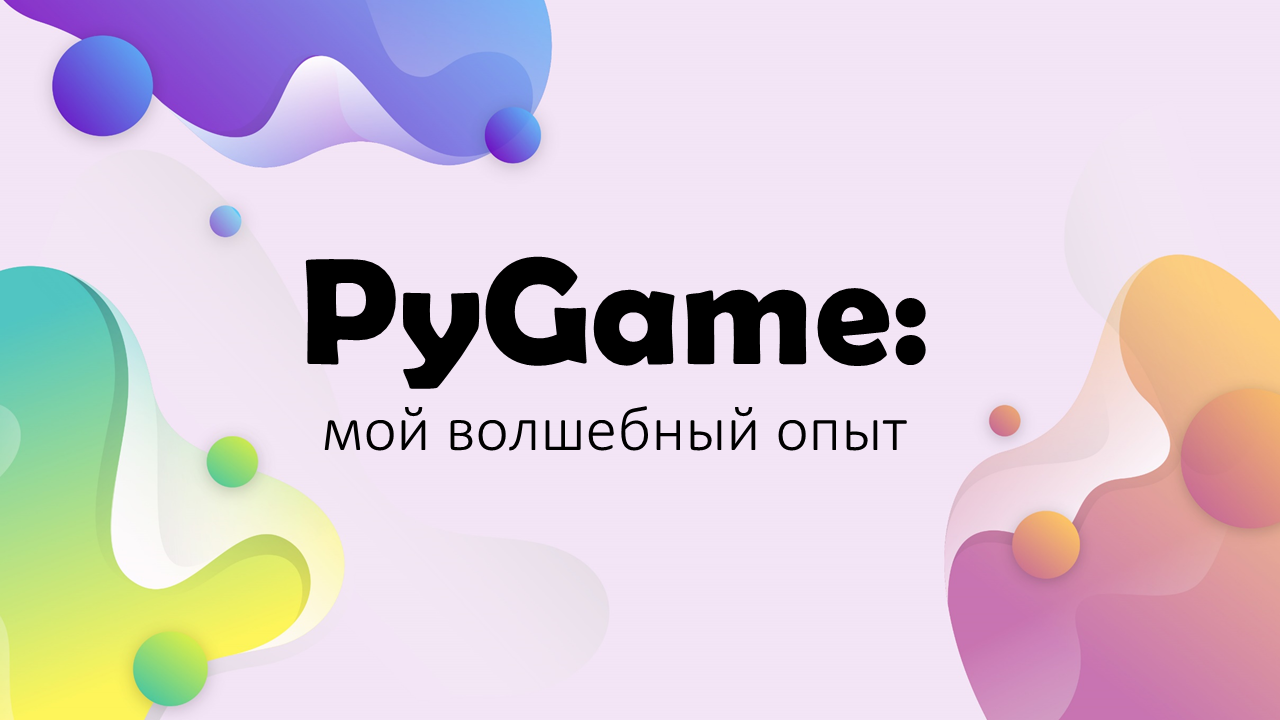

In [11]:
from IPython.display import Image
Image(filename='download.png', width = 700)

## Автор: Дорошенко Александра, СПбАУ РАН, 2020

### GitLab repo : https://gitlab.com/iamsosha/worm_life 

_______________________________________________________________________________________________________________________________
### Для начала немного информации о фреймворке PyGame.



Авторы: Lenard Lindstrom, René Dudfield, Pete Shinners, Nicholas Dudfield, Thomas Kluyver, and others 

Разработчики: PyGame Community

Дата выхода: 28 октября 2000


Фреймворк написан на: Python, C, Cython, Assembler

ОС: Cross-platform

Открытый исходный код: https://github.com/pygame/pygame/

Сайт: www.pygame.org

Документация: https://www.pygame.org/docs/

Pygame не входит в стандартную библиотеку Python, то есть не поставляется с установочным пакетом, а требует отдельной установки. 

Linux:

В Windows:

Проверить, что все установилось нормально, можно запустив игру aliens, включенную в модуль examples (примеры) библиотеки pygame:

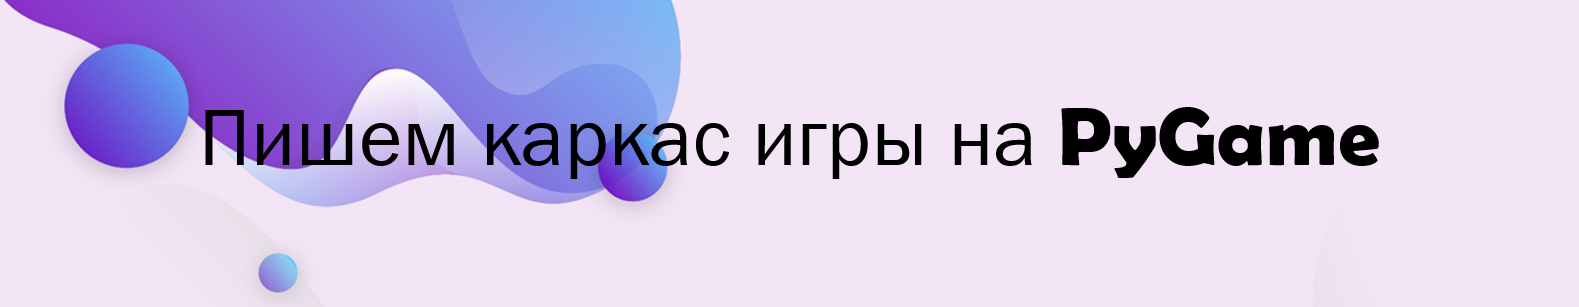

In [8]:
from IPython.display import Image
Image(filename='download (1).png', width = 500)

Для начала импортируем модуль pygame. Кроме функций и классов самого модуля иблиотека содержит ряд вложенных модулей, которые также следует импортировать. Однако их очень много и в код пришлось бы добавлять очень много import-ов. Вместо этого в pygame есть функция init(), которая инициализирует все модули библиотеки. Теперь выведем на экран окно игры с помощью функции set_mode() модуля display:

In [ ]:
import config
import pygame
from pygame.locals import *

pygame.init()
screen = pygame.display.set_mode((config.WIDTH, config.HEIGHT))

Если выполнить этот код, то появится окно размером 600x400 пикселей и сразу закроется.

Функция set_mode() принимает три аргумента – размер в виде кортежа из двух целых чисел, флаги и глубину цвета. Флаги предназначены для переключения на аппаратное ускорение, полноэкранный режим, отключения рамки окна и др. Их можно не указывать. В этом случае окно займет весь экран, цветовая глубина будет соответствовать системной. Обычно указывают только первый аргумент – размер окна.

Высота и ширина экрана берется из специального файла config.py:

In [ ]:
WIDTH = 1920
HEIGHT = 1080
FPS = 30

BLOCKSIZE = 25
FOODSIZE = 50
FOODSPAWNRATE = 1.5
PURPLE = (255, 0, 255)
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)

Воторой import написали для упрощения работы над кодом в дальнейшем. Благодаря этой строчке теперь не нужно писать название модуля: например, вместо pygame.QUIT теперь можно писать прото QUIT.

Функция set_mode() возвращает объект типа Surface (поверхность), его называют display surface - поверхность экрана. Именно эту поверхность мы видим на экране монитора.

Обновление содержимого окна (каждому пикселю заново устанавливается цвет): 

In [ ]:
pygame.display.update()

In [ ]:
pygame.display.flip()

Если функции update() не передавать аргументы, то будут обновляться значения всей поверхности окна. Но можно передать  прямоугольную область или список таких областей. В этом случае обновляться будут только они.

Очевидно, окно программы будет моментально закрываться сразу после выполнения. Для этого нужно создать бесконечный цикл, который и будет постоянно отрисовывать окно игры до тех пор, пока мы не нажмем на "QUIT".

In [ ]:
import config
import pygame
from pygame.locals import *

pygame.init()

#подключим сразу музыку
pygame.mixer.init()

screen = pygame.display.set_mode((config.WIDTH, config.HEIGHT))

#название окна
pygame.display.set_caption("WORM's LIFE")

clock = pygame.time.Clock()

screen = pygame.display.get_surface()

#задаем композицию для проигрывания, громкость и количество повторов 
pygame.mixer.music.load('ambient.wav')
pygame.mixer.music.set_volume(0.5)
pygame.mixer.music.play(loops=100)

import field_objects


# Цикл игры
running = True

while running:

    # Держим цикл на правильной скорости
    clock.tick(config.FPS)
    
    # Ввод процесса (события)
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False


_______________________________________________________________________________________________________________________________
### Немного геймдизайна

О чем же будет наша игра, каким образом будет осуществляться управление и какие основные метрики будут присутствовать?

В этот раз будем делать ремейк всем известной змейки - игру про червя, который может ползать и собирать еду. Если червь ест, он удлиняется, также он может откусить себе хвост. 

Условная камера будет неподвижна, то есть игровая область меняться не будет. На поле будет появляться еда и целью игры будет собрать как можно больше еды и максимально удинить червя, ну и конечно сделать так, чтобы он не съел сам себя.

Отлично, с дизайном примерно определились. Теперь нужно понять, какие модули необходимо написать для реализации функционала нашей игры:

1. Сама "змейка" - червь. Более подробно обсудим ее дальше.
    - упаравление
    - взаимодействие с объектами на экране
    - откусывание хвоста
    

2. Объекты на поле:
    - генератор объектов со случайными координатами на экране (в зоне видимости)
    - взаимодейсвие объектов со змейкой
    
 
3. Связать все воедино в основном цикле игры.

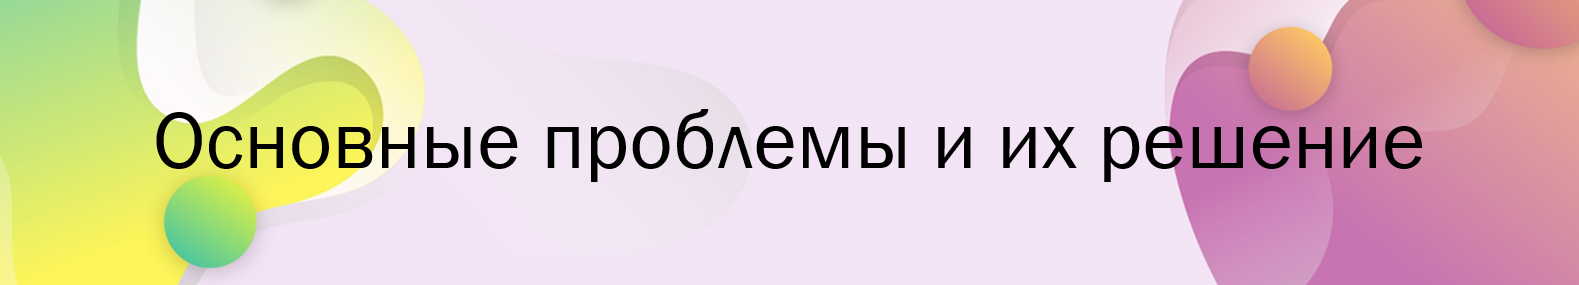

In [10]:
from IPython.display import Image
Image(filename="download (2).png", width = 500)

### 1. Змейка 

Одной из основных проблем при реализиции игры была сама змейка. Понятно, как заставить ее двигаться. А как же заставить ее укорачиваться и удлинняться? В конце-концов, как сделать так, чтобы она поворачивалась при этом более-менее плавно? 

Решение пришло довольно быстро: МОЖНО СДЕЛАТЬ ЗМЕЙКУ ИЗ БЛОКОВ! 

Класс блоков описан в следующем коде:

In [ ]:
# директория с картинками
img_dir = path.join(path.dirname(__file__), 'pictures')

# словарь с текстурами и головой змейки
snake_objects = dict(
    head_img=pygame.image.load(img_dir+ '\head_0.png').convert_alpha(),
    worm_img=pygame.image.load(img_dir+ '\worm_1.png').convert_alpha())


# блоки, из которых состоит змейка
class Block(pygame.sprite.Sprite):
    def __init__(self, direction, x, y, nextBlock=None, image="worm_img"):
        pygame.sprite.Sprite.__init__(self)
        self.direction = None
        self.image = snake_objects[image]
        self.rect = self.image.get_rect()
        
        #устанавливаем размер блоков
        self.rect.width = config.BLOCKSIZE
        self.rect.height = config.BLOCKSIZE

        self.nextBlock = nextBlock
        self.changeDirection(direction)

        self.rect.x = x
        self.rect.y = y
        self.rotatePoints: List[RotatePoint] = []

        self.image = pygame.transform.scale(self.image, (config.BLOCKSIZE, config.BLOCKSIZE))
        self.image = pygame.transform.rotate(self.image,270)

Каждый блок знает про свой предыдущий блок. Это необходимо для того, чтобы змейка могла плавно поворачиваться. Когда блок перед данным решает повернуться, точка добавляется в список точек поворота для следующего блока. Таким образом, каждый блок "знает", где ему нужно повернуть.

In [ ]:
# точки поворота с направлением поворота
class RotatePoint:
    def __init__(self, x, y, direction):
        self.x = x
        self.y = y
        self.direction = direction

        
# чтобы управлять змейкой
class Direction(Enum):
    UP = 1
    DOWN = 2
    RIGHT = 3
    LEFT = 4

Реализуем теперь метод поворота для одного блока. Просто описываем все возможные случаи:

In [ ]:
def changeDirection(self, direction):
    # нельзя поворачивать в противоположную сторону, например LEFT -> RIGHT
        print(direction.value)
        if (direction == Direction.RIGHT and self.direction == Direction.LEFT):
            return
        if (direction == Direction.LEFT and self.direction == Direction.RIGHT):
            return
        if (direction == Direction.UP and self.direction == Direction.DOWN):
            return
        if (direction == Direction.DOWN and self.direction == Direction.UP):
            return

        prev_dir = self.direction
        self.direction = direction

        # проверяем, наличие след. блока и добавляем точку поворота в список для него
        if self.nextBlock is not None:
            self.nextBlock.rotatePoints.append(RotatePoint(self.rect.x, self.rect.y, direction))

        # поворот картинки для змейки (чтобы выглядело адекватно)
        if direction == Direction.UP:
            self.dx, self.dy = 0, -5
            if prev_dir == Direction.LEFT:
                self.image = pygame.transform.rotate(self.image, 270)
            elif prev_dir == Direction.RIGHT:
                self.image = pygame.transform.rotate(self.image, 90)

        elif direction == Direction.DOWN:
            self.dx, self.dy = 0, 5
            if prev_dir == Direction.LEFT:
                self.image = pygame.transform.rotate(self.image, 90)
            elif prev_dir == Direction.RIGHT:
                self.image = pygame.transform.rotate(self.image, 270)

        elif direction == Direction.RIGHT:
            self.dx, self.dy = 5, 0
            if prev_dir == Direction.UP:
                self.image = pygame.transform.rotate(self.image, 270)
            elif prev_dir == Direction.DOWN:
                self.image = pygame.transform.rotate(self.image, 90)

        elif direction == Direction.LEFT:
            self.dx, self.dy = -5, 0
            if prev_dir == Direction.UP:
                self.image = pygame.transform.rotate(self.image, 90)
            elif prev_dir == Direction.DOWN:
                self.image = pygame.transform.rotate(self.image, 270)

Также необходимы методы добавления блока и обновления змейки:

In [ ]:
# создание следующего блока
def setNextBlock(self, block):
    self.nextBlock = block

# обновление змейки, проверка на поворот
def update(self):
    self.rect.x += self.dx
    self.rect.y += self.dy
    for point in self.rotatePoints:
        if (abs(point.x - self.rect.x) <= 2) and (abs(point.y - self.rect.y) <= 2):
            self.rect.x = point.x
            self.rect.y = point.y
            self.changeDirection(point.direction)
            self.rotatePoints.remove(point)
            break


Напишем теперь класс змейки и его методы (инициализация, добавление в список всех блоков, добавление через определенный сдвиг, равный длине блока, удаление, обновление, отрисовка на экране, смена направления). Управлять мы можем только первым блоком змейки - условной "головой", а все остальные, как уже было сказано ранее, подстраиваются под него.

In [ ]:
# класс змейки
class Snake:
    def __init__(self):
        # звук, когда змейка налетает на объект с поля
        self.sound_eat = pygame.mixer.Sound('eat.ogg')
        self.blocks: List[Block] = []
        self.sprites = pygame.sprite.Group()
        self.addCurrBlock(Block(Direction.DOWN, config.WIDTH / 2, config.HEIGHT / 2, image="head_img"))
        for i in range(1, 20):
            self.addBlock()
            
    def addCurrBlock(self, block: Block):
        self.blocks.append(block)
        self.sprites.add(block)
        if len(self.blocks) == 1:
            return
        self.blocks[len(self.blocks) - 2].setNextBlock(block)

    def addBlock(self):
        dx, dy = 0, 0
        last_block = self.blocks[len(self.blocks) - 1]
        if last_block.direction == Direction.UP:
            dx, dy = 0, config.BLOCKSIZE
        elif last_block.direction == Direction.DOWN:
            dx, dy = 0, -config.BLOCKSIZE
        elif last_block.direction == Direction.RIGHT:
            dx, dy = -config.BLOCKSIZE, 0
        elif last_block.direction == Direction.LEFT:
            dx, dy = config.BLOCKSIZE, 0

        block = Block(last_block.direction, last_block.rect.x + dx, last_block.rect.y + dy)
        last_block.setNextBlock(block)
        self.blocks.append(block)
        self.sprites.add(block)

    def deleteBlock(self, idx):
        idx += 1
        for i in range(idx, len(self.blocks)):
            self.sprites.remove(self.blocks[i])

        while len(self.blocks) != idx:
            self.blocks.remove(self.blocks[idx])
        self.blocks[idx - 1].setNextBlock(None)

    def update(self):
        self.sprites.update()
        for i in range(2, len(self.blocks) - 1):
            if self.blocks[0].rect.colliderect(self.blocks[i].rect):
                self.deleteBlock(i)
                break

    def draw(self, screen):
        self.sprites.draw(screen)

    def changeDirection(self, direction: Direction):
        if self.blocks[0].rect.colliderect(self.blocks[1]):
            return
        self.blocks[0].changeDirection(direction)


### 2. Объекты на экране 

Импортируем все необходимые модули и создаем словарь со всеми видами объектов (еды), которые могут спавниться на поле:

In [ ]:
from distutils.command.config import config

import pygame
import random
from os import path
import snake
import randomdict
import config

img_dir = path.join(path.dirname(__file__), 'pictures')

trivial_objects = randomdict.RandomDict(
    pizza_img=pygame.image.load(path.join(img_dir, "pizza.png")).convert_alpha(),
    borgar_img=pygame.image.load(path.join(img_dir, "borgar.png")).convert_alpha(),
    carrot_img=pygame.image.load(path.join(img_dir, "carrot.png")).convert_alpha(),
    steak_img=pygame.image.load(path.join(img_dir, "steak.png")).convert_alpha(),
    icecream_img=pygame.image.load(path.join(img_dir, "icecream.png")).convert_alpha(),
    puncakes_img=pygame.image.load(path.join(img_dir, "puncakes.png")).convert_alpha(),
    puncakes1_img=pygame.image.load(path.join(img_dir, "puncakes_1.png")).convert_alpha())

Создадим теперь класс Объект:

In [ ]:
class Object(pygame.sprite.Sprite):
    def __init__(self):
        pygame.sprite.Sprite.__init__(self)
        self.image = trivial_objects.random_value()
        self.rect = self.image.get_rect()
        self.rect.x = random.randint(config.FOODSIZE, config.WIDTH - config.FOODSIZE)
        self.rect.y = random.randint(config.FOODSIZE, config.HEIGHT - config.FOODSIZE)
        self.rect.height = config.FOODSIZE
        self.rect.width = config.FOODSIZE
        self.image = pygame.transform.scale(self.image, (config.FOODSIZE, config.FOODSIZE))

И класс всех объектов на экрае и его методы (создание, удаление, обновление, отрисовка на экране):

In [ ]:
All_Objects = pygame.sprite.Group()
All_ObjectsL = []

seconds_before_spawn = 3

class AllObjects(Object):
    def __init__(self):
        pygame.sprite.Sprite.__init__(self)
        self.seconds_before_spawn = config.FOODSPAWNRATE


    def GenerateObject(self):

        while True:
            newObj = Object()
            All_Objects.add(newObj)
            All_ObjectsL.append(newObj)
            return All_Objects


    def deleteObject(self, one_object):
        All_Objects.remove( one_object)
        All_ObjectsL.remove(one_object)


    def updateObjects(self,ply: snake.Snake):
        self.seconds_before_spawn -= 1/30
        if self.seconds_before_spawn <= 0:
            self.seconds_before_spawn = config.FOODSPAWNRATE
            self.GenerateObject()
        for i in range(0, len(All_ObjectsL)):
            if ply.blocks[0].rect.colliderect(All_ObjectsL[i].rect):
                ply.addBlock()
                self.deleteObject(All_ObjectsL[i])
                ply.sound_eat.play()
                break

    def draw(self, screen):
        All_Objects.draw(screen)

### 3. Цикл игры

In [2]:
import config
import pygame
from pygame.locals import *

def toggle_fullscreen():
    screen = pygame.display.get_surface()
    tmp = screen.convert()
    caption = pygame.display.get_caption()
    cursor = pygame.mouse.get_cursor()  # Duoas 16-04-2007

    w, h = screen.get_width(), screen.get_height()
    flags = screen.get_flags()
    bits = screen.get_bitsize()

    pygame.display.quit()
    pygame.display.init()

    screen = pygame.display.set_mode((w, h), flags ^ FULLSCREEN, bits)
    screen.blit(tmp, (0, 0))
    pygame.display.set_caption(*caption)

    pygame.key.set_mods(0)  # HACK: work-a-round for a SDL bug??

    pygame.mouse.set_cursor(*cursor)  # Duoas 16-04-2007

    return screen

pygame.init()
pygame.mixer.init()
screen = pygame.display.set_mode((config.WIDTH, config.HEIGHT))
pygame.display.set_caption("WORM's LIFE")
clock = pygame.time.Clock()
toggle_fullscreen()
screen = pygame.display.get_surface()


import snake

pygame.mixer.music.load('ambient.wav')
pygame.mixer.music.set_volume(0.5)
pygame.mixer.music.play(loops=100)

import field_objects

player = snake.Snake()
#playersprite = pygame.sprite.RenderPlain(player)

background = pygame.image.load(field_objects.img_dir+ '\ground.png').convert()
background_rect = background.get_rect()

all_objs = field_objects.AllObjects()
# Цикл игры
running = True
while running:

    # Держим цикл на правильной скорости
    clock.tick(config.FPS)
    # Ввод процесса (события)
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        if event.type == pygame.KEYDOWN:
            if event.key == 273:
                player.changeDirection(snake.Direction.UP)
            elif event.key == 274:
                player.changeDirection(snake.Direction.DOWN)
            elif event.key == 275:
                player.changeDirection(snake.Direction.RIGHT)
            elif event.key == 276:
                player.changeDirection(snake.Direction.LEFT)
            elif event.key == 27:
                running = False
            elif event.key == pygame.K_SPACE:
                for i in range(5):
                    all_objs.GenerateObject()

    # Обновление
     player.update()


    # Рендеринг
    screen.fill(config.WHITE)
    screen.blit(background, background_rect)
    player.draw(screen)

    all_objs.updateObjects(ply=player)
    all_objs.draw(screen)
    pygame.display.flip()

pygame.quit()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 79)

### GUI 

Создадим небольшрй интерфейс для входа в игру и ее завершения:

In [ ]:
import subprocess
import os
import thorpy
import pygame
import Scripts.config
path = os.path

def run_game():
    os.system('python game.py')


application = thorpy.Application((Scripts.config.WIDTH, Scripts.config.HEIGHT), "Worm's Life")

thorpy.set_theme("round")
start_button = thorpy.make_button("START", func=run_game)
quit_button = thorpy.make_button("QUIT", func=quit)

start_button.set_font_size(36)
# start_button.scale_to_title()

quit_button.set_font_size(36)
# quit_button.scale_to_title()

start_button.set_size((300, 75))
quit_button.set_size((300, 75))

start_button.set_main_color((255, 99, 71))
quit_button.set_main_color((255, 127, 80))

elements = [start_button, quit_button]

menu_box = thorpy.Box(elements=elements)
menu_box.fit_children(margins=(30, 30))
menu_box.center()

menu_box.set_main_color((220, 220, 220, 180)) 

img_dir = path.join(path.dirname(file), 'pictures')
background_img = pygame.image.load(path.join(img_dir, 'ground.png'))
background = thorpy.Background.make(image=background_img, elements=elements)
thorpy.store(background)
background.finish()

menu = thorpy.Menu(elements=background, fps=Scripts.config.FPS)
menu.play()

### Арт и звуковое оформление

Весь пиксельный арт в этой игре был создан мной с помощью сайта https://www.pixilart.com/

Музыка взята с бесплатных музыкальных стоков.

In [12]:
from IPython.display import Image

list = [
'head3.png',
'worm.png',
'candy.png',
'borgar.png',
'pizza.png',
'coin.png'
]

for image in list:
    display(Image(filename=image))

## Результаты 

Видео с игрой: https://yadi.sk/i/XiDYrNeWthVQQg

На данном видео запечатлен весь основной функционал игры. Есть много моментов, которые требуют доработки, например:
- необходимо как-то ограничивать выход змейки за пределы экрана
- нет какой-то шкалы достижений (например максимальной длины змейки и счетчика монеток)

Но и на настоящий момент игра выглядит неплохо, а также работает нормально. Мне очень понравилось писать игру с помощью модуля PyGame. Это совершенно не похоже на привычное асоздание игр с помощью современных игровых движков (например Unity или Unreal Engine). В будущем мне пригодится полученны опыт. 